# Random Forest Classification on the Digits Dataset
This notebook demonstrates how to use scikit-learn's `RandomForestClassifier` for multi-class classification on the Digits dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
sns.set_theme()


## Data Loading & Exploration
Load the Digits dataset (8×8 images of handwritten digits) and inspect its properties.

In [ ]:
digits = load_digits()
X = digits.data      # shape (1797, 64)
y = digits.target    # labels 0–9
print(f"Feature matrix shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print("Label distribution:", np.bincount(y))

Feature matrix shape: (1797, 64)
Number of classes: 10
Label distribution: [178 182 177 183 181 182 181 179 174 180]


## Visualizing Sample Images
Display a few examples from each class.

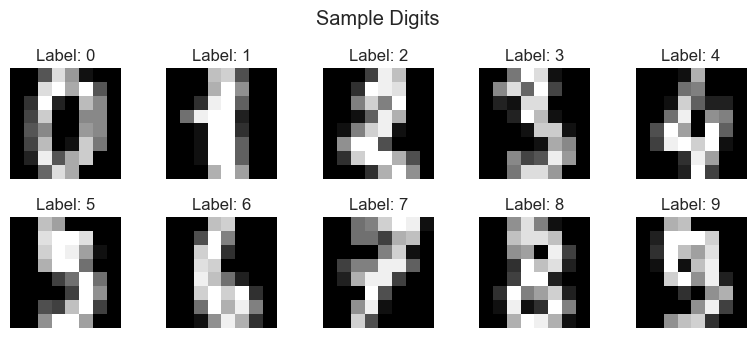

In [4]:
plt.figure(figsize=(8,8))
for digit in range(10):
    idx = np.where(y == digit)[0][0]
    ax = plt.subplot(5, 5, digit+1)
    plt.imshow(X[idx].reshape(8,8), cmap='gray')
    plt.title(f"Label: {digit}")
    plt.axis('off')
plt.suptitle('Sample Digits')
plt.tight_layout()
plt.show()


## Train/Test Split
Split the data into 80% training and 20% testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 1437, Test samples: 360


## Training Default Random Forest
Fit a `RandomForestClassifier` with default settings.

In [ ]:
rf = RandomForestClassifier(random_state=42, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("OOB Score:", rf.oob_score_)

Test Accuracy: 0.961
OOB Accuracy: 0.973


## Confusion Matrix & Classification Report
Evaluate the model on the test set.

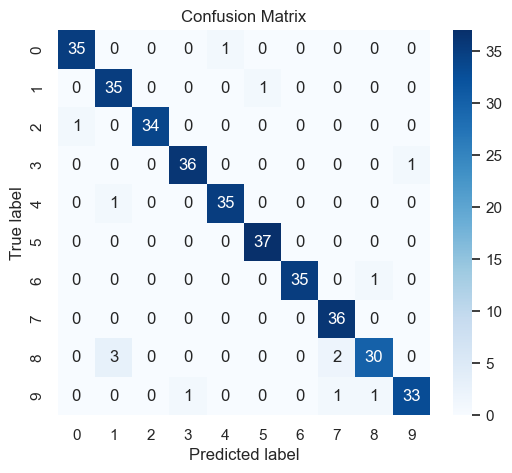

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

The matrix is very diagonal. There are little inaccuracies in prediction, demonstrating the robustness of the random forest model.

In [9]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.90      0.97      0.93        36
           2       1.00      0.97      0.99        35
           3       0.97      0.97      0.97        37
           4       0.97      0.97      0.97        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



## Classification Results

- **Precision**: The model's precision is high across all classes, indicating that when it predicts a digit, it is usually correct. The precision ranges from 0.90 (class 1) to 1.00 (classes 2 and 6).
- **Recall**: The recall is also strong, showing the model's ability to correctly identify all instances of each class. The recall ranges from 0.86 (class 8) to 1.00 (classes 5 and 7).
- **F1-Score**: The F1-score, which balances precision and recall, is consistently high, with most classes achieving scores above 0.94.
- **Accuracy**: The overall accuracy of the model is 96%, demonstrating its effectiveness in classifying the digits.
- **Macro Average**: The macro average of precision, recall, and F1-score is 0.96, indicating balanced performance across all classes.
- **Weighted Average**: The weighted average, which accounts for the support (number of samples) of each class, is also 0.96.

The model performs exceptionally well, with minor misclassifications in classes 1, 8, and 9. These results highlight the robustness of the Random Forest Classifier for this multi-class classification task.

## Feature Importances as Pixel Heatmap
Display the importance of each pixel feature reshaped as an 8×8 image.

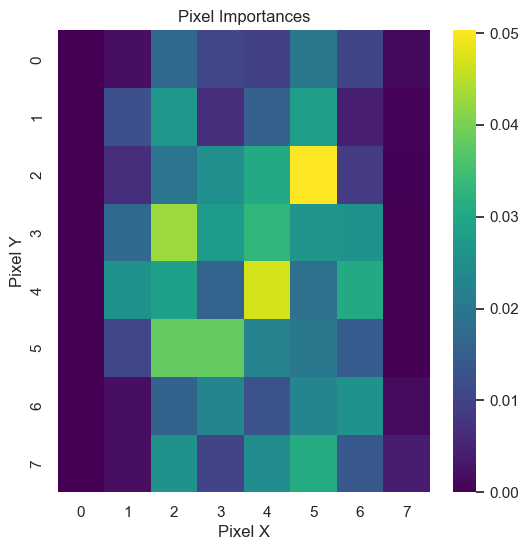

In [11]:
importances = rf.feature_importances_
imp_image = importances.reshape(8,8)
plt.figure(figsize=(6,6))
sns.heatmap(imp_image, cmap='viridis')
plt.title('Pixel Importances')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

## Decision Boundary via PCA Projection
Project data to 2D with PCA, train RF on the two principal components, and visualize decision regions.

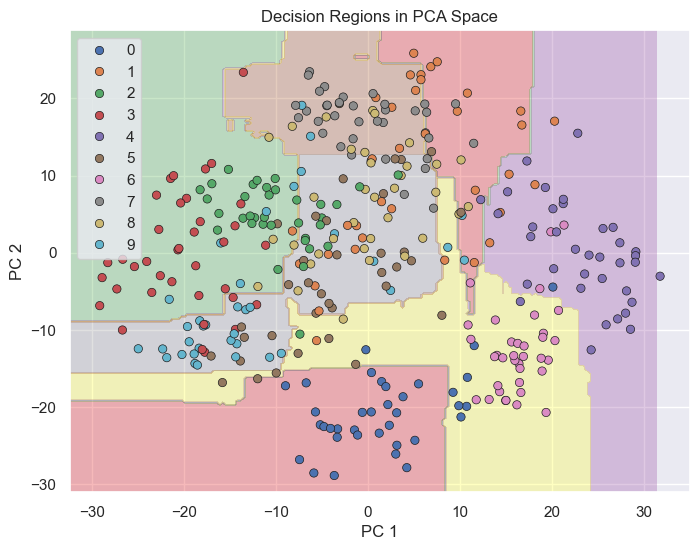

In [12]:
# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train RF on 2D PCA data
rf_pca = RandomForestClassifier(max_depth=5, random_state=42)
rf_pca.fit(X_pca, y_train)

# Meshgrid
xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 200),
    np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = rf_pca.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')
sns.scatterplot(x=X_test_pca[:,0], y=X_test_pca[:,1], hue=y_test, palette='deep', edgecolor='k')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Regions in PCA Space')
plt.show()

## OOB Error vs. Number of Trees
Plot out-of-bag error as a function of n_estimators.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


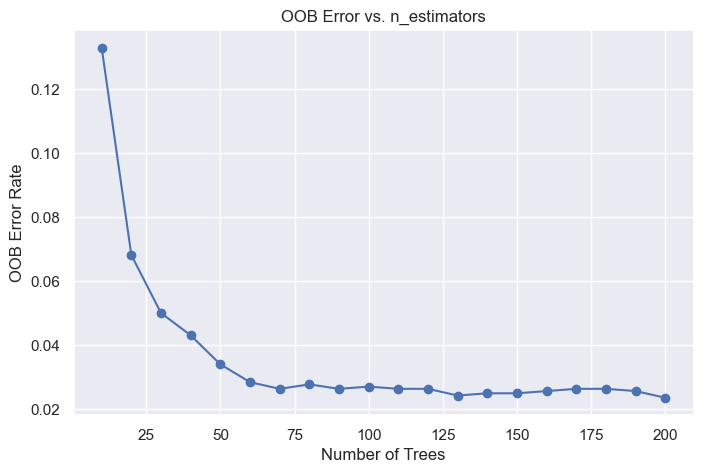

In [13]:
oob_errors = []
n_trees = list(range(10, 201, 10))
for n in n_trees:
    rf_temp = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf_temp.fit(X_train, y_train)
    oob_errors.append(1 - rf_temp.oob_score_)
plt.figure(figsize=(8,5))
plt.plot(n_trees, oob_errors, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error vs. n_estimators')
plt.grid(True)
plt.show()

The OOB error, an unbiased estimate of the leave-one-out cross validation, decreases with the number of trees, as expected. The optimal number of trees seems to be at about 70 trees.

## Validation Curve: max_depth
Plot training and cross-validation accuracy vs. tree depth.

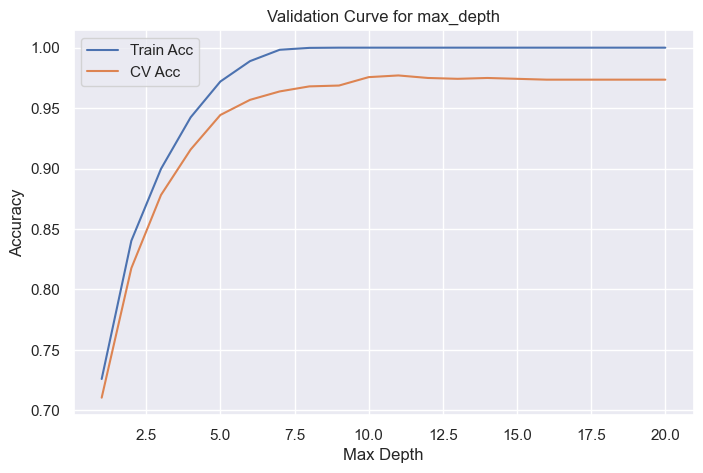

In [14]:
param_range = range(1, 21)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train, y_train, param_name='max_depth', param_range=param_range,
    cv=5, scoring='accuracy'
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(param_range, train_mean, label='Train Acc')
plt.plot(param_range, test_mean, label='CV Acc')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve for max_depth')
plt.legend()
plt.grid(True)
plt.show()

The optimal max_depth value seems to be reached at 9.

## Running with the optimal paramters we found

In [15]:
# Train a Random Forest with optimal parameters
rf_optimal = RandomForestClassifier(n_estimators=90, max_depth=9, random_state=42, oob_score=True)
rf_optimal.fit(X_train, y_train)

# Evaluate the model
y_pred_optimal = rf_optimal.predict(X_test)
print(f"Test Accuracy with optimal parameters: {accuracy_score(y_test, y_pred_optimal):.3f}")
print("OOB Score with optimal parameters:", rf_optimal.oob_score_)

Test Accuracy with optimal parameters: 0.964
OOB Score with optimal parameters: 0.9679888656924147


The accuracy is a slight improvement over our initial default model.

## Discussion
- Random Forest combines many decision trees to reduce variance and improve generalization.  
- OOB error closely matches test error, providing a built-in validation.  
- Overall, Random Forests provide strong classification performance with relatively little tuning.